In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("mako", as_cmap=True) #getting color palette for project

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv


## Project Scope
<ul>
<li>Using solar generation and associated temperature data to explore time series forecasting.</li>
<li>Compare the performance of XGBoost and a deep learning LSTM model to make a 2-Day forecast of power generation</li>
<li>See what impact including the temperature data has on the forecast</li>
<li>Experiment with feature engineering and test the impact differernt features have on the models</li>
<li>Fine tune the models</li>
<li>Report on what model is ultimately more successful and comment on possible project extensions</li>
</ul>

## Loading and exploring data
This data was taken from two solar plants in India of the course of 34 days in 15 minute intervals. The weather data is on the plant level (just measured from one sensor) and the generation data is gathered from individual inverters across the plant. More information can be found here: 
<a href="https://www.kaggle.com/datasets/anikannal/solar-power-generation-data">Data Card</a>. Credit to 
<a href="https://www.kaggle.com/anikannal">Ani Kannal</a> for uploading this dataset to Kaggle.

In [2]:
plt1_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plt2_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plt1_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plt2_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [3]:
plt1_gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
plt1_gen.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0
68777,17-06-2020 23:45,4135001,zVJPv84UY57bAof,0.0,0.0,5910.000,7363272.0


Notes: PLANT_ID is the same throughout, so it can be safely removed. The generation for these times is 0, because it is nighttime. Since we are targeting plant level generation, I will groupby DATE_TIME and sum the data for each timestamp. I will then make the datetime the index. First, I'll check for nulls and make sure there is data for every timestamp.

In [5]:
plt1_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


Notes: The dtypes make sense. I will need to make the DATE_TIME a datetime dtype. No nulls detected here, but there still could be outliers or nulls encoded in a different way.

In [6]:
plt1_gen.describe().T

,count,mean,std,min,25%,50%,75%,max
PLANT_ID,68778.0,4.135001e+06,0.000000,4135001.0,4.135001e+06,4.135001e+06,4.135001e+06,4135001.000
DC_POWER,68778.0,3.147426e+03,4036.457169,0.0,0.000000e+00,4.290000e+02,6.366964e+03,14471.125
AC_POWER,68778.0,3.078028e+02,394.396439,0.0,0.000000e+00,4.149375e+01,6.236187e+02,1410.950
DAILY_YIELD,68778.0,3.295969e+03,3145.178309,0.0,0.000000e+00,2.658714e+03,6.274000e+03,9163.000
TOTAL_YIELD,68778.0,6.978712e+06,416271.982856,6183645.0,6.512003e+06,7.146685e+06,7.268706e+06,7846821.000


In [7]:
plt1_gen.SOURCE_KEY.nunique()

22

Notes: There are 22 sources so I would expect there to be 34 * 24 * 4 * 22 = 71808 rows altogether. However, there are only 68777, so 3031 or ~4% of the total are missing. Although probably not enough to greatly inpact our model, I will plan on imputing the missing data. First, I will explore whether these are just some inverters missing data or they are missing at the plant level.

In [8]:
plt1_gen.groupby('SOURCE_KEY').count().DATE_TIME.count()

22

Notes: Each inverter would have 34 * 24 * 4 = 3264 data points if every timestamp was present.

In [9]:
plt1_gen.groupby('SOURCE_KEY').count().DATE_TIME.min()

3104

Notes: The inverter with the least number of readings still has ~95% of the excepted number.

In [10]:
#Switching DATE_TIME column to datetime dtype.
plt1_gen['DATE_TIME'] = pd.to_datetime(plt1_gen.DATE_TIME, format='%d-%m-%Y %H:%M')
plt1_gen.DATE_TIME.nunique() #output 3158

3158

Note: There are also some entire timestamps missing on the plant level. First I will rollup the inverters to the plant level and then fill in the missing timestamps by creating the full excepted datetime range and merging it with the current dataframe 

In [11]:
plt1_gen = plt1_gen.drop('PLANT_ID', axis=1)
plt1_gen = plt1_gen.groupby('DATE_TIME').sum(numeric_only=True)

<Axes: >

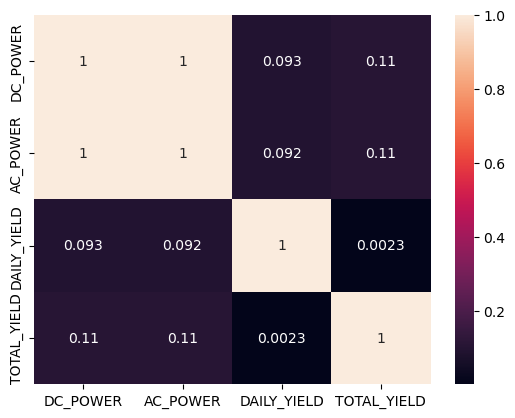

In [12]:
sns.heatmap(plt1_gen.corr(), annot =True)

Notes: Not surprising DC_POWER and AC_POWER are highly correlated. Since I am ultimately interested in power generation after the inverter inverts to AC, I will make AC_POWER the target, droping the other columns.

In [13]:
plt1_gen = plt1_gen.drop(['DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD'], axis=1)

In [14]:
plt1_gen.index

DatetimeIndex(['2020-05-15 00:00:00', '2020-05-15 00:15:00',
               '2020-05-15 00:30:00', '2020-05-15 00:45:00',
               '2020-05-15 01:00:00', '2020-05-15 01:15:00',
               '2020-05-15 01:30:00', '2020-05-15 01:45:00',
               '2020-05-15 02:00:00', '2020-05-15 02:15:00',
               ...
               '2020-06-17 21:30:00', '2020-06-17 21:45:00',
               '2020-06-17 22:00:00', '2020-06-17 22:15:00',
               '2020-06-17 22:30:00', '2020-06-17 22:45:00',
               '2020-06-17 23:00:00', '2020-06-17 23:15:00',
               '2020-06-17 23:30:00', '2020-06-17 23:45:00'],
              dtype='datetime64[ns]', name='DATE_TIME', length=3158, freq=None)

In [15]:
#Next I will make a full datetime range series to merge with the plt1_gen dataframe
date_time_full = pd.date_range('2020-05-15', '2020-06-17 23:45', freq='15min')
date_time_full = pd.Series(date_time_full, name='DATE_TIME') #making a Series to allow merging

In [16]:
df = plt1_gen.merge(date_time_full, right_on='DATE_TIME', left_index=True, how='right')
df.index = df.pop('DATE_TIME')
df = df.sort_index()

<Axes: ylabel='Count'>

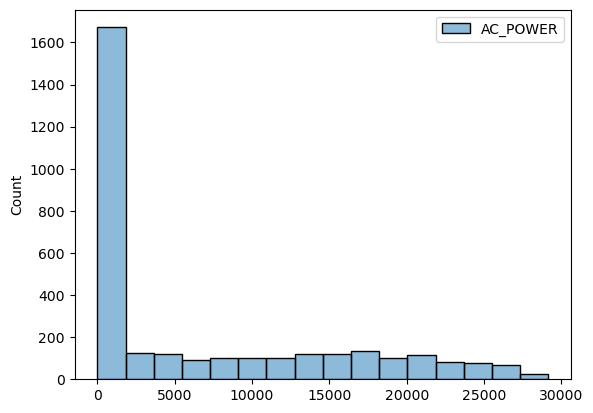

In [17]:
sns.histplot(df)